In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import typing as tp
from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, feature, transform, filters, measure

In [83]:
# Step 1: Load the image
image = io.imread("data/im2.jpg")
gray = color.rgb2gray(image)


def plot_images(images, titles, figsize=(20, 20)):
    fig, axs = plt.subplots(1, len(images))
    fig.set_size_inches(figsize)
    for ax, image, title in zip(axs, images, titles):
        ax.set_title(title)
        ax.imshow(image, cmap="gray")

In [105]:
def n_largest_indices(matrix, n):
    """
    Returns the 2D indices of the n largest values from a 2D array of integers.

    :param matrix: 2D list or numpy array of integers
    :param n: Integer, number of largest values to return
    :return: List of 2D indices of the n largest integers from the array
    """
    # Convert the matrix to a NumPy array if it isn't already
    np_matrix = np.array(matrix)

    # Flatten the NumPy array to a 1D array
    flat_array = np_matrix.flatten()

    # Find the indices of the n largest values using np.argpartition
    n_largest_indices = np.argpartition(flat_array, -n)[-n:]

    # Convert the flat indices to original 2D indices
    original_indices = [
        np.unravel_index(index, np_matrix.shape) for index in n_largest_indices
    ]

    # Sort the indices based on the values in descending order
    sorted_indices = np.array(
        sorted(
            original_indices,
            key=lambda x: flat_array[np.ravel_multi_index(x, np_matrix.shape)],
            reverse=True,
        )
    )

    return sorted_indices


def my_hough_transform(
    img_binary: np.ndarray, d_rho: int, d_theta: float, n: int
) -> tp.Tuple[np.ndarray, np.ndarray, int]:
    # Define the dimentions of the accumulator array H
    diagonal = np.sqrt(img_binary.shape[0] ** 2 + img_binary.shape[1] ** 2)

    # Define the theta angles and rho values
    theta_angles = np.arange(-np.pi, np.pi, d_theta)
    rho_values = np.arange(-diagonal, diagonal, d_rho)

    # Initialize the Hough accumulator array H
    num_thetas = len(theta_angles)
    num_rhos = len(rho_values)
    H = np.zeros([num_rhos, num_thetas], dtype=np.uint64)

    # Pre-compute sin and cos
    sins = np.sin(theta_angles)
    coss = np.cos(theta_angles)

    # Consider edges only
    xs, ys = np.where(img_binary > 0)

    for x, y in zip(xs, ys):
        for t in range(num_thetas):
            # compute the rhos for the given point for each theta
            current_rho = x * coss[t] + y * sins[t]
            # for each rho, compute the closest rho among the rho_values below it
            # the index corresponding to that rho is the one we will increase
            # rho_pos = np.where(current_rho > rho_values)[0][-1]
            rho_pos = np.argmin(np.abs(current_rho - rho_values))
            H[rho_pos, t] += 1
        break

    L = [
        [rho_values[rho], theta_angles[theta]] for rho, theta in n_largest_indices(H, n)
    ]

    return H, L, ...

In [6]:
H, L, res = my_hough_transform(
    img_binary=binary_image, d_rho=1, d_theta=np.pi / 180, n=10
)

In [ ]:
def my_corner_harris(img: np.ndarray, k: float, sigma: float) -> np.ndarray:
    pass

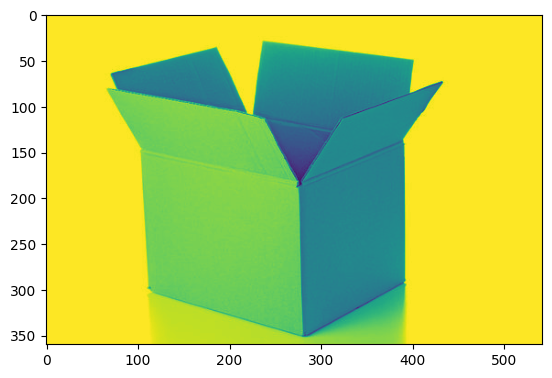

In [195]:
plt.imshow(gray_image)

In [221]:
Sx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

Sy = Sx.T

G = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16

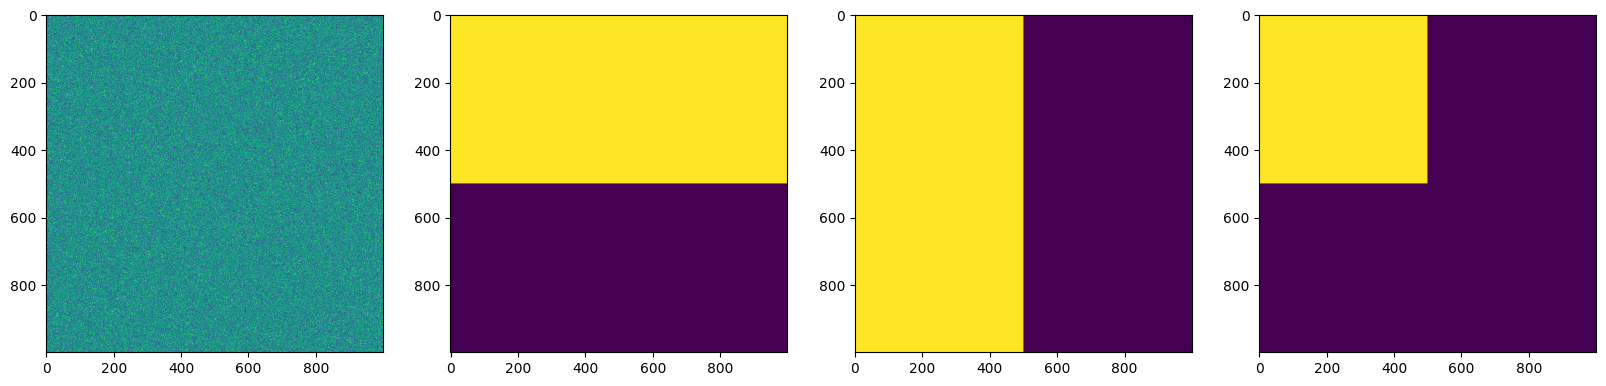

In [217]:
fig, axs = plt.subplots(1, 4)
fig.set_size_inches(20, 20)
flat_image = np.random.random((1000, 1000)) * 255
horizontal_edge = np.zeros_like(flat_image)
horizontal_edge[:500,] = 255
vertical_edge = np.zeros_like(flat_image)
vertical_edge[:, :500] = 255
corner = np.zeros_like(flat_image)
corner[:500, :500] = 255
axs[0].imshow(flat_image)
axs[1].imshow(horizontal_edge)
axs[2].imshow(vertical_edge)
axs[3].imshow(corner)

In [219]:
def corner_response(image, k, Sx, Sy, G):
    # compute first derivatives
    dx = cv.filter2D(image, ddepth=-1, kernel=Sx)
    dy = cv.filter2D(image, ddepth=-1, kernel=Sy)

    # Gaussian filter (blur)
    A = cv.filter2D(dx * dx, ddepth=-1, kernel=G)
    B = cv.filter2D(dy * dy, ddepth=-1, kernel=G)
    C = cv.filter2D(dx * dy, ddepth=-1, kernel=G)

    # compute corner response at all pixels
    return (A * B - (C * C)) - k * (A + B) * (A + B)

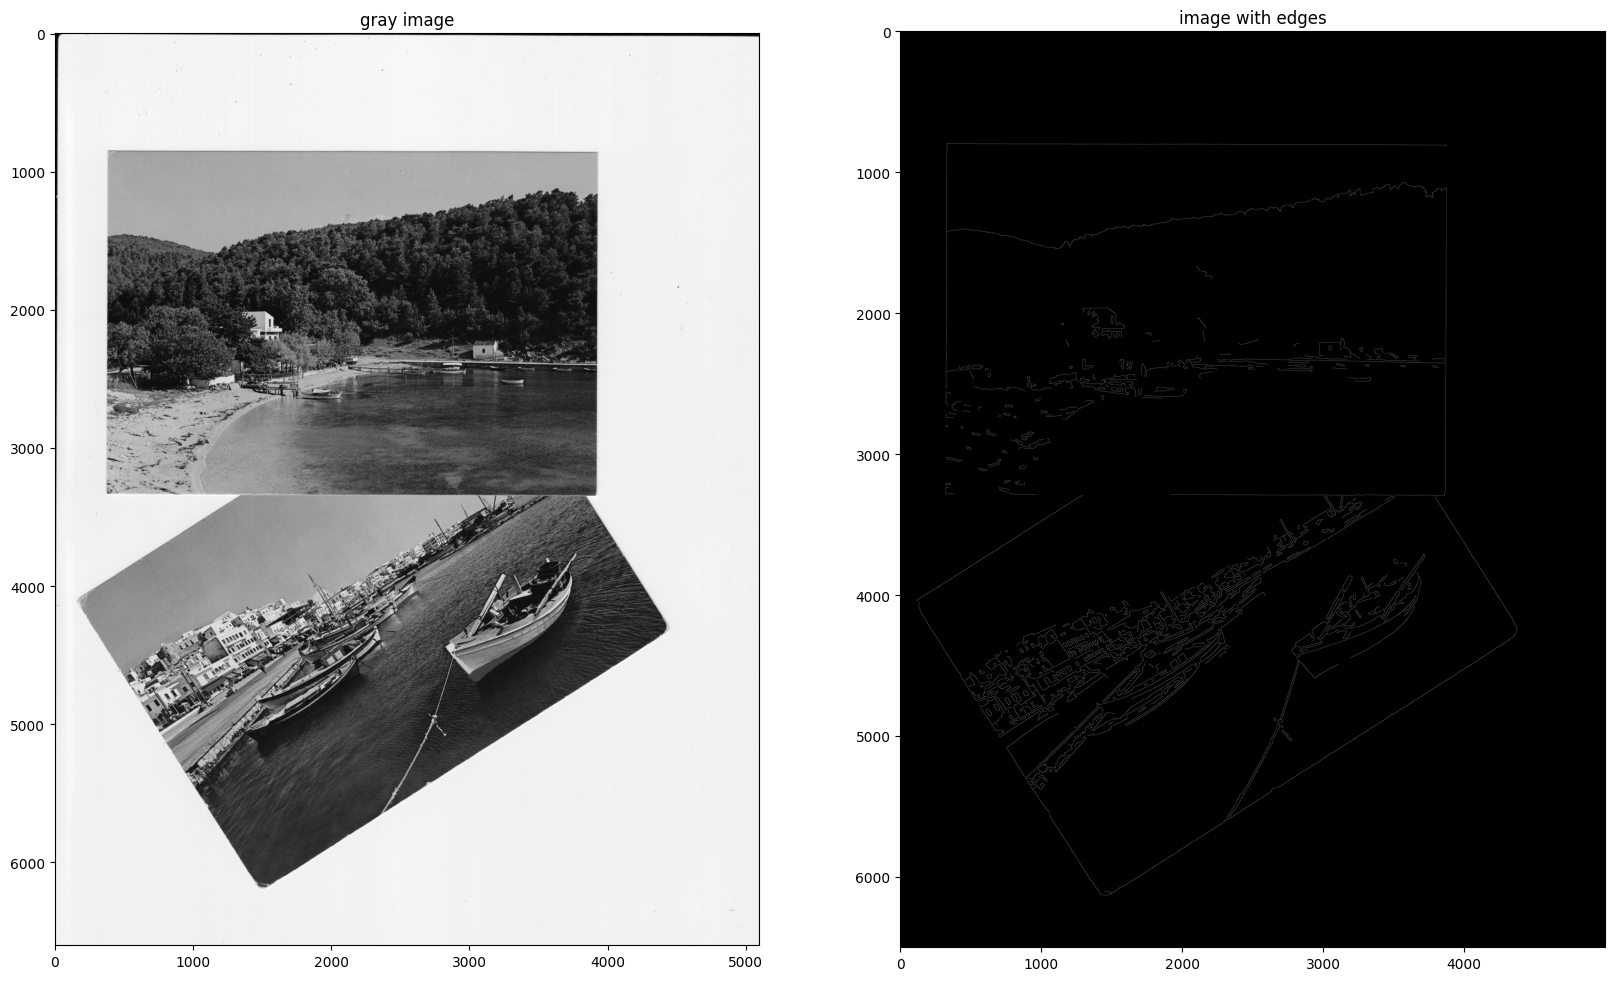

In [124]:
# Step 2: Edge detection

edges = feature.canny(gray[50:-50, 50:-50], sigma=5)

plot_images([gray, edges], ["gray image", "image with edges"])

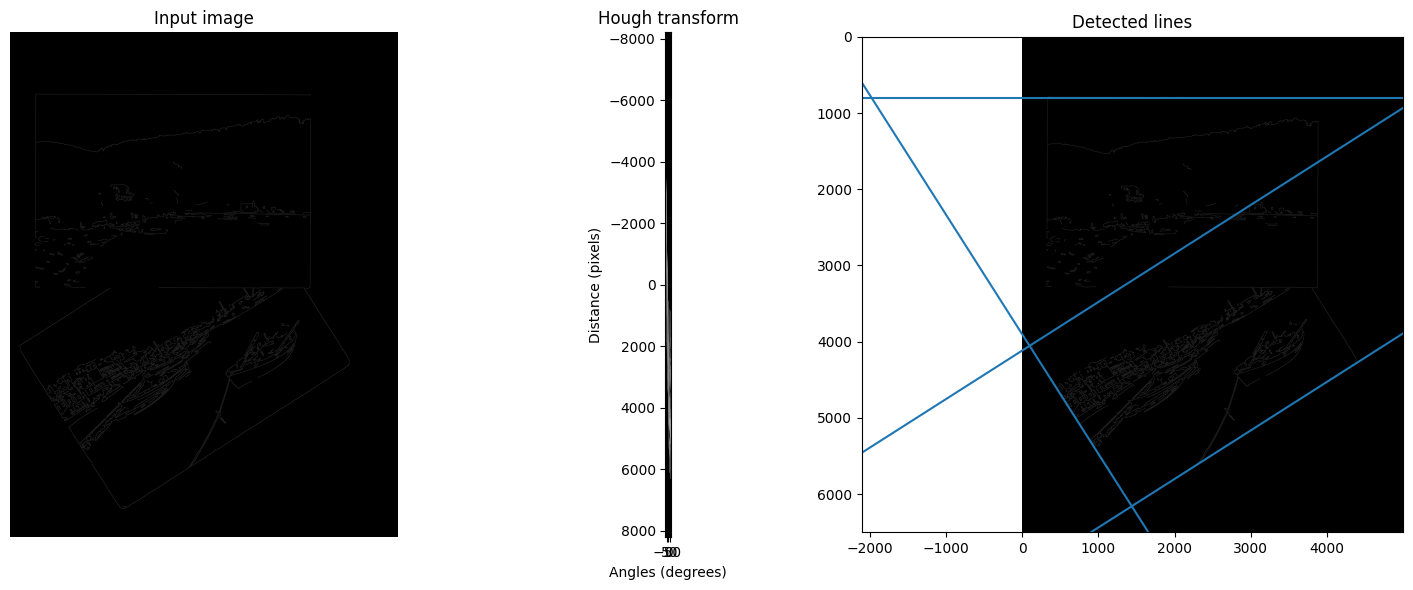

In [136]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm

image = edges.copy()
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(image, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title("Input image")
ax[0].set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [
    np.rad2deg(theta[0] - angle_step),
    np.rad2deg(theta[-1] + angle_step),
    d[-1] + d_step,
    d[0] - d_step,
]
ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title("Hough transform")
ax[1].set_xlabel("Angles (degrees)")
ax[1].set_ylabel("Distance (pixels)")
ax[1].axis("image")

ax[2].imshow(image, cmap=cm.gray)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title("Detected lines")

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi / 2))

plt.tight_layout()
plt.show()

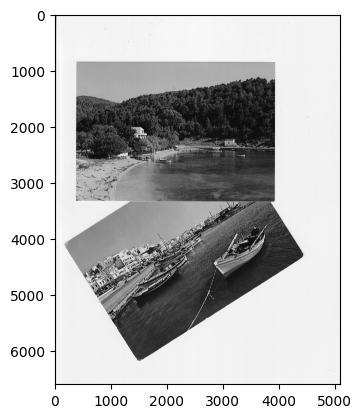

In [140]:
from matplotlib import pyplot as plt


plt.imshow(gray, cmap="gray")

# coords = corner_peaks(corner_harris(image), min_distance=5, threshold_rel=0.02)
# coords_subpix = corner_subpix(image, coords, window_size=13)

# fig, ax = plt.subplots()
# ax.imshow(image, cmap=plt.cm.gray)
# ax.plot(
#     coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=6
# )
# ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
# ax.axis((0, 310, 200, 0))
# plt.show()